In [4]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_path = './train.csv'
test_path = './test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [6]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
df_train.groupby('target').count()

,qid,question_text
target,,
0,1225312,1225312
1,80810,80810


In [8]:
df_train.where(df_train['target'] == 1).dropna()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1.0
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1.0
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1.0
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1.0
115,000537213b01fd77b58a,Which races have the smallest penis?,1.0
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1.0
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1.0
144,00068875d7c82a5bcf88,Why do Europeans say they're the superior race...,1.0
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on...,1.0
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1.0


In [9]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [10]:
df_train['question_text'][130757]

'What are the literary devices used in the novel "Les Misérables" by Victor Hugo?'

[Text(0.5, 0, 'Target')]

[Text(0, 0.5, 'count')]

Text(0.5, 1.0, 'Distribution of Negative & Positive Insincere question')

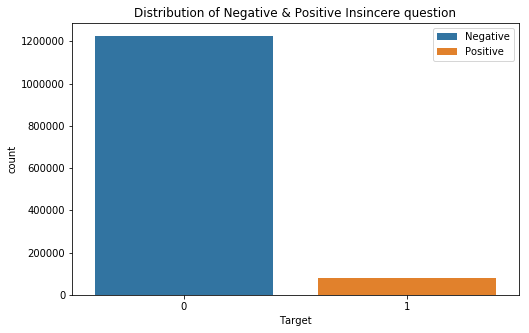

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df_train.target.unique(),y=df_train.target.value_counts(), hue = ['0', '1'], dodge = False);

#ax.set_title('Distribution of Negative & Positive Insincere question')
ax.set(xlabel= 'Target')
ax.set(ylabel= 'count')

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Negative', 'Positive'])

plt.title('Distribution of Negative & Positive Insincere question')
plt.show()

In [12]:
print(type(df_train['question_text']))
df_train['question_text'] = df_train.question_text.progress_apply(lambda x: re.sub('\n', ' ', x))


Progress:   1%|          | 8712/1306122 [00:00<00:14, 87119.04it/s]

<class 'pandas.core.series.Series'>


Progress: 100%|██████████| 1306122/1306122 [00:03<00:00, 393270.11it/s]


In [13]:
df_train['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [14]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [15]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

In [16]:
TEXT = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
LABELS = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_fields = [
    ('qid', None),
    ('question_text', TEXT),
    ('target', LABELS)
]

In [17]:
print(type(df_train))

<class 'pandas.core.frame.DataFrame'>


In [18]:
## seperating

In [19]:
def split_train_test(df_train, test_size=0.2):
    train, val = train_test_split(df_train, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [20]:
traindf, valdf = split_train_test(df_train, test_size=0.2)

In [22]:
traindf.to_csv('traindf.csv', index = False)
valdf.to_csv('valdf.csv',index= False)

In [23]:
##crate torchtext dataset
traindf.head()

,qid,question_text,target
0,3a820a95342d28ad402f,How is strategic positioning is different from...,0
1,9fca299caa0cf8f12eac,What is the best way for promote Facebook mark...,0
2,de23f10ad011a6fb13c7,How much energized proton radiation does the I...,0
3,d2eef16340896e963a63,Would any Indian men want to marry a women tha...,0
4,27d584db9bd46b6ab44e,Which is the best business for startups in Ind...,0


In [24]:
%%time
trainds, valds = data.TabularDataset.splits(path='./', 
                                            format='csv', train='traindf.csv', validation='valdf.csv', 
                                            fields=train_fields, skip_header=True)

CPU times: user 10min 4s, sys: 6.77 s, total: 10min 11s
Wall time: 2h 30min 12s


In [25]:
type(trainds)
len(trainds), len(valds)
trainds[0].question_text

torchtext.data.dataset.TabularDataset

(1044897, 261225)

['how',
 'is',
 'strategic',
 'positioning',
 'is',
 'different',
 'from',
 'marketing',
 'positioning']

In [26]:
ex = trainds.examples[0]
type(ex)
trainds.fields.items()
ex.question_text
ex.target

torchtext.data.example.Example

dict_items([('qid', None), ('question_text', <torchtext.data.field.Field object at 0x1a31607c18>), ('target', <torchtext.data.field.Field object at 0x1a19d1f4e0>)])

['how',
 'is',
 'strategic',
 'positioning',
 'is',
 'different',
 'from',
 'marketing',
 'positioning']

'0'

### Load pretrained word vectors and building vocabulary

In [27]:
%%time
vec = vocab.Vectors('word2vec.txt', './')


CPU times: user 134 ms, sys: 160 ms, total: 294 ms
Wall time: 393 ms


In [28]:
len(vec.vectors)

258110

In [29]:
%%time
TEXT.build_vocab(trainds, valds, max_size=160000, vectors=vec)
LABELS.build_vocab(trainds)

CPU times: user 15.5 s, sys: 1.49 s, total: 17 s
Wall time: 18.5 s


In [30]:
TEXT.vocab.vectors.shape

torch.Size([160002, 50])

In [31]:
TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([-1.5454, -0.3855, -1.3414, -0.1820,  0.9111, -0.0511,  2.3909,  0.0982,
        -1.2502,  2.0930,  0.4491,  2.8606, -0.1207, -0.8120, -1.3948, -2.5018,
        -0.8181,  0.5812,  4.7760,  0.1531, -1.6925,  1.2428, -0.4360,  0.9675,
         1.3102,  0.2022,  1.0768, -0.2839, -2.1971, -0.6728,  1.5275,  3.3601,
         2.2180, -0.0426, -0.4355, -0.2776,  1.4450, -0.6309,  0.7143, -0.4283,
         0.4671,  1.4224, -3.1848,  0.8012,  3.7483, -1.3917, -1.5730, -1.9213,
         1.7973, -3.2339])